<center><h1> Data Camp Project</h1> </center>
<center><h1>Bicycle surplus prediction</h1></center>
<center> <h4>Authors : Ghassen Ben Hassine, Firas Rhimi, Etienne Lenaour, Ryme Kabak, Elyes Karray, Mehdi Bennaceur</h4></center>


<div style="text-align: center;">

<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<center>
<img border="0" src="https://miro.medium.com/max/4096/1*GJ45uUnc49T-D5LdYn7CfQ.jpeg" width="100%"> </td>
</center>

  </tr>
</table> 
</div>



## Table of Contents

0. [Introduction](#Introduction)
1. [Business Motivation](#Business-Motivation)
2. [Data Construction](#Data)
3. [Evaluation metric](#Evaluation-metric)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Feature Engineering](#Feature-Engineering)
6. [Predictions](#Predictions)

# Introduction

New York Bike Sharing system provides a carbon-free way of transportation to more than 50 millions person each month. More than 800 hundreds bike docking stations are available across the city and are open 24/7. It was in part conceived to decrease traffic and usage in other public transport services (subway etc...).


There are two main dataset we will use:

* `bike_data.csv` - bike usage in NYC.
* `weather_data.csv` -  weather data in NYC.

The goal here will be to come up with an algorithm that tells us when and where CitiBike should recharge/discharge a docking station.

# Business Motivation 


# Data  


As stated before, we will be working with two datasets : 
## bike_data.csv
This dataset was built from an extract of https://www.citibikenyc.com/system-data. It includes historical data of bike trips in NYC between 2016 and 2018 : 
* `Trip Duration` - the duration of the trip in seconds
* `Start Time` -Start Date and Time 
* `Stop Time` - Stop Date and Time 
* `Start Station ID` 
* `Start Station Name`
* `Start Station Longitude` - Spatial Coordinates
* `Start Station Latitude` - Spatial Coordinates
* `End Station ID` 
* `End Station Name`
* `End Station Longitude` - Spatial Coordinates
* `End Station Latitude` - Spatial Coordinates
* `Bike ID` 
* `User Type` - Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member
* `Birth Year` - Birth Year of the customer
* `Gender` - Gender of the customer : Zero=unknown; 1=male; 2=female

In [7]:
# Imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap

In [8]:
from get_data import *
raw_data = get_bike_data()
raw_data.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0


From this raw dataset, we construct a new dataset that will be used in the challenge as a training set. This new dataset will include : 
* `Year` 
* `Month` 
* `Day` 
* `Hour` 
* `Station ID` 
* `Station Name`
* `Longitude` 
* `Latitude` 
* `Surplus` : The target we want to predict : the difference between the number of bikes that come in a given station and the number of bikes that leave this station in a given date.

The preprocessing to get the train set is done in the get_data.py file. 


In [10]:
train_data = get_flow_data(raw_data)
train_data.head(5)

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,1.0
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,0.0
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,2.0
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,-1.0
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,2.0


In [ ]:
import json
stations_path = 'Data/stations.json'
with open(stations_path, 'r') as f:
    stations_with_capacities = json.load(f)

u = 51
stations = list(stations_with_capacities.keys())

train_data = train_data.loc[train_data['Station Name'].isin(stations)]
train_data.loc[train_data['Station Name'] == stations[u]]

station_surpluses = train_data.loc[train_data['Station Name'] == stations[u]]['Surplus']
print(f'max surplus {max(station_surpluses)}, min surplus {min(station_surpluses)}, capacity {stations_with_capacities[stations[u]]}')

train_data['Current Load'] = train_data.groupby('Station Name').cumsum()['Surplus']
station_loads = train_data.loc[train_data['Station Name'] == stations[u]]['Current Load'] 
print(f'max load {max(station_loads)}, min load {min(station_loads)}, capacity {stations_with_capacities[stations[u]]}')

# max(train_data.loc[train_data['Station Name'] == stations[51]]['Surplus'])
# stations_with_capacities[stations[51]]

## Weather_data.csv


In [12]:
weather = pd.read_csv('Data\Weather Data\Train_Weather.csv')
weather.head()

,Hour,Temperature,Apparent Temperature,Wind,Relative Humidity,Date
0,00:51,6°C,4°C,Variable à 7 Km/h,49%,2016-01-01
1,01:51,5°C,4°C,Variable à 6 Km/h,53%,2016-01-01
2,02:51,5°C,3°C,280°7 Km/h,57%,2016-01-01
3,03:51,5°C,2°C,280°15 Km/h,57%,2016-01-01
4,04:51,4°C,0°C,270°17 Km/h,61%,2016-01-01


# Evaluation metric

The idea is not to penalize in the same way a prediction of a higher surplus than the true one and the prediction of a lower surplus than the true one. We may define the loss as follows(called Pinball loss) : 


$l(y_{true},y_{pred})= max(-(1-\tau)(y_{pred}-y_{true}),\tau (y_{pred}-y_{true})) = \begin{cases} \tau(y_{pred}-y_{true}) & \text{if } y_{pred} \geq y_{true} \\  -(1-\tau)(y_{pred}-y_{true}) & \text{if } y_{pred} < y_{true}\end{cases}$

where $\tau \in ]0,1[$ is a parameter that quantifies the degree of penalization at each case.

In our case, we would like to penalize more the fact that the model overestimates the surplus (predicts a higher value of surplus than the true value). This can be done by choosing a value of $\tau >0.5 $. In this challenge, we chose $\tau=0.7$. 

First we visualize the loss function and then we create our scoring metric.


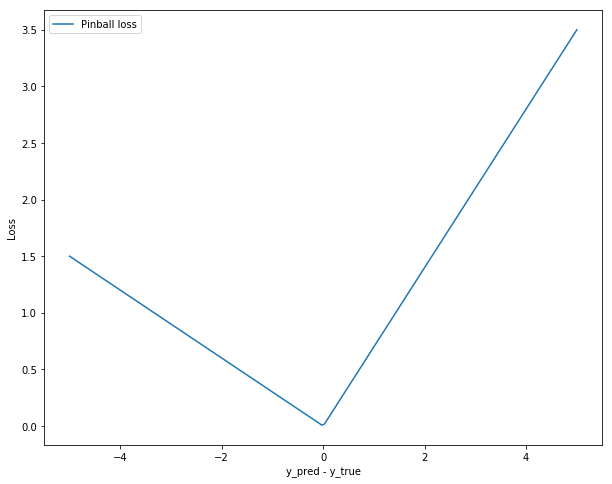

In [13]:
# visualize the pinball loss 
plt.figure(figsize=(10, 8))
tau = 0.7
x= np.linspace(-5,5,200) # x= y_pred - y_true
plt.plot(x,np.maximum(-(1-tau)*x,tau*x),label= "Pinball loss")
plt.xlabel('y_pred - y_true')
plt.ylabel('Loss')
plt.legend()

In [14]:
# define scoring function 

from sklearn.metrics import make_scorer

def loss(y_true, y_pred, tau=0.7): 
    return np.mean(np.maximum(-(1 - tau) * (y_pred - y_true), tau * (y_pred - y_true)))

pinball_loss = make_scorer(loss, greater_is_better=False) # scoring=fan_loss in cross_val_score

# Exploratory Data Analysis

In [15]:
X_df, y_array = train_data.drop(columns= ['Surplus']) ,train_data['Surplus'].values

In [16]:
train_data.count()

Year            511903
Month           511903
Day             511903
Hour            511903
Station ID      511903
Station Name    511903
Longitude       511903
Latitude        511903
Surplus         511903
dtype: int64

In [17]:
train_data.describe(include='all')

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
count,511903.000000,511903.000000,511903.000000,511903.000000,511903.000000,511903,511903.000000,511903.000000,511903.000000
unique,NaN,NaN,NaN,NaN,NaN,199,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Grove St PATH,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,20557,NaN,NaN,NaN
mean,2017.111619,6.963298,15.755520,13.518585,3244.058263,NaN,-73.988233,40.690377,0.000000
std,0.822150,3.229329,8.795291,5.687800,132.903913,NaN,2.117686,1.164652,3.682759
min,2016.000000,1.000000,1.000000,0.000000,127.000000,NaN,-74.096937,0.000000,-54.000000
25%,2016.000000,4.000000,8.000000,9.000000,3194.000000,NaN,-74.055701,40.717732,-1.000000
50%,2017.000000,7.000000,16.000000,14.000000,3209.000000,NaN,-74.046305,40.721651,0.000000
75%,2018.000000,10.000000,23.000000,18.000000,3269.000000,NaN,-74.038914,40.727596,1.000000


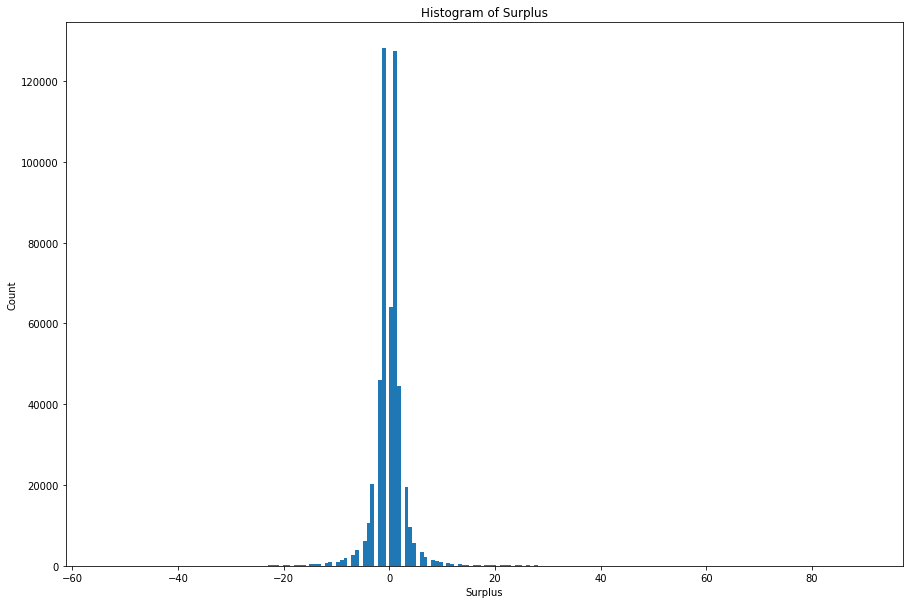

In [18]:
# Histogram
plt.figure(figsize=(15,10))
plt.hist(y_array, bins=200)
plt.title('Histogram of Surplus')
plt.xlabel('Surplus')
plt.ylabel('Count')
plt.show()


Let's visualize the  visulazing the position of our docking stations in New York City:

In [19]:
#dockers coordinates 
coord=train_data[["Longitude", "Latitude"]]
coord2=coord.drop_duplicates(keep='first', inplace=False)  
coord2.shape

(213, 2)

In [24]:
map_1 = folium.Map(location=[40.717937, -73.982155], zoom_start=11,tiles='OpenStreetMap') # manually added centre
coord2.reset_index(inplace = True, drop = True)
for i in range(len(coord2)):  
        long = coord2.loc[coord2.index ==i]['Longitude'].values[0]
        lati = coord2.loc[coord2.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  fill_color = '#FF3333',
                            number_of_sides = 8, radius = 5).add_to(map_1)

In [25]:
display(map_1)

In [26]:
# import cv2
# img = cv2.imread("Data/Maps/map_1.png")
# plt.imshow(img)

In [27]:
pos_surplus = train_data[train_data['Surplus']>0]   #215350
neg_surplus = train_data[train_data['Surplus']<0]   #222587
null_surplus = train_data[train_data['Surplus']==0] #63573

In [28]:
coord_pos=pos_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False) #184  
coord_neg=neg_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False)  #63
coord_null=null_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False) #63


In [40]:
map_2 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
map_3 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
map_4 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre

coord_pos.reset_index(inplace = True, drop = True)
coord_neg.reset_index(inplace = True, drop = True)
coord_null.reset_index(inplace = True, drop = True)

    
for i in range(len(coord_null)):  
        long = coord_null.loc[coord_null.index ==i]['Longitude'].values[0]
        lati = coord_null.loc[coord_null.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  
                            number_of_sides = 6, radius = 4).add_to(map_2)
        
        
for i in range(len(coord_neg)):  
        long = coord_neg.loc[coord_neg.index ==i]['Longitude'].values[0]
        lati = coord_neg.loc[coord_neg.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long], 
                            number_of_sides = 5, radius = 4).add_to(map_4)
    
for i in range(len(coord_pos)):  
        long = coord_pos.loc[coord_pos.index ==i]['Longitude'].values[0]
        lati = coord_pos.loc[coord_pos.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  
                            number_of_sides = 5, radius = 4).add_to(map_3)


In [42]:
display(map_4)

In [ ]:
# img_2 = cv2.imread("Data/Maps/map_2.png")
# plt.imshow(img_2)


In [ ]:
# img_4 = cv2.imread("Data/Maps/map_4.png")
# plt.imshow(img_4)

The dockers that tend to have negative or null surplus are located in Jersey City, which is another city that is 6.24 kms away from NYC. This can be interpreted as the following: people who work in New York might prefer to live in Jersey City (which is more affordable) and can therefore use the bikes to "travel" to New York (for work or other purposes), leading therefore to more bikes OUT than bikes IN, and hence a negative or null surplus. So it is important to be able to monitor the surplus so that people from that area continue to use bikes for their short trips.

In [ ]:
# img_3 = cv2.imread("Data/Maps/map_3.png")
# plt.imshow(img_3)

Here, we can see that the dockers are distributed across different districts of New York. These dockers tend to have positive surplus, which means that there are more bikes coming in than bikes leaving across Manhattan and Brooklyn. 

In [43]:
# Mean Surplus for a given station
df= train_data[['Surplus','Station ID']].groupby('Station ID').mean()
df.head()


,Surplus
Station ID,
127.0,1.0
128.0,1.0
146.0,1.0
147.0,1.0
152.0,1.0


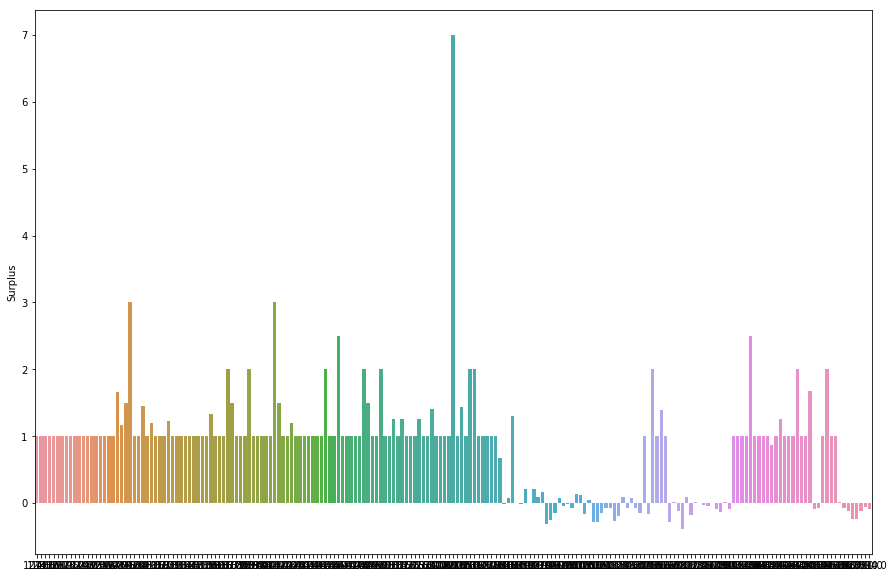

In [44]:
plt.figure(figsize=(15,10))
stations = list(df.index)
mean_surplus = df['Surplus']
sns.barplot(stations,mean_surplus)

In [23]:
df[df['Surplus']==7]

,Surplus
Station ID,
2021.0,7.0


In [24]:
train_data[train_data['Station ID']==2021] # We have the information for just 1 hour for this station 

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
106179,2017.0,1.0,25.0,17.0,2021.0,W 45 St & 8 Ave,-73.988597,40.759291,7.0


In [25]:
# Mean Surplus for a given Hour 
df=train_data[['Surplus','Hour']].groupby('Hour').mean()
df.head()

,Surplus
Hour,
0.0,0.046175
1.0,0.062973
2.0,0.053318
3.0,0.026421
4.0,-0.007485


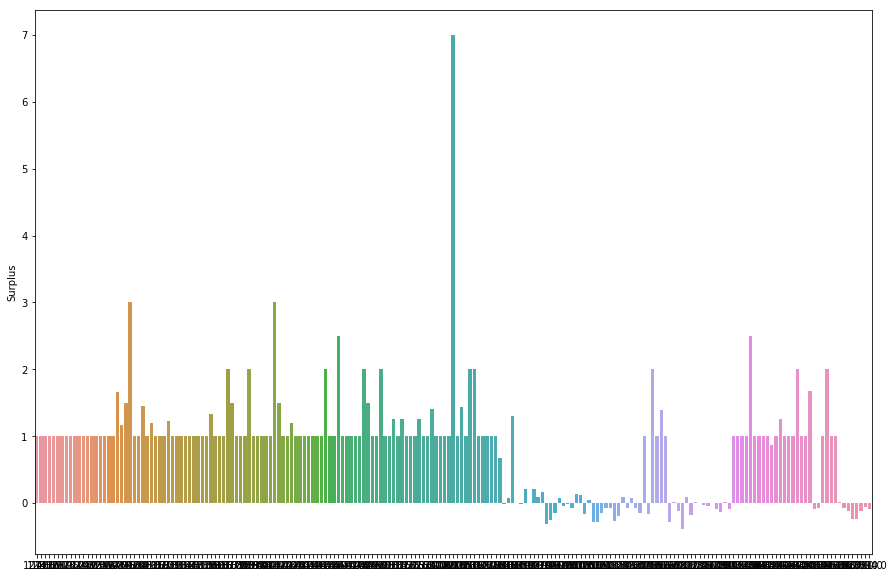

In [47]:
plt.figure(figsize=(15,10))
hour = list(df.index)
mean_surplus = df['Surplus']
sns.barplot(hour,mean_surplus)

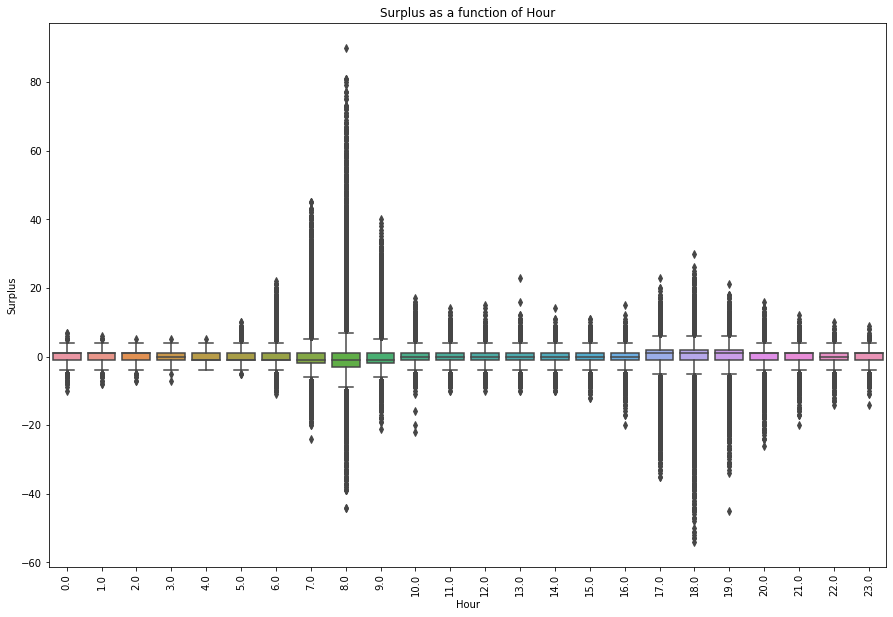

In [27]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Hour'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Hour')
plt.show()


## Weather Data

# Feature Engineering

## Day of week 

In [28]:
ts = pd.to_datetime(X_df[['Year','Month','Day']])
X_df['Weekdday']=ts.dt.weekday
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Weekdday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,4
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,4
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,4
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,4
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,4


In [29]:
## Groupby day of the week
train_data['Weekday'] = ts.dt.weekday 
df=train_data[['Surplus','Weekday']].groupby('Weekday').mean()
df.head()

,Surplus
Weekday,
0,0.001376
1,0.000160
2,0.000143
3,-0.000672
4,-0.001446


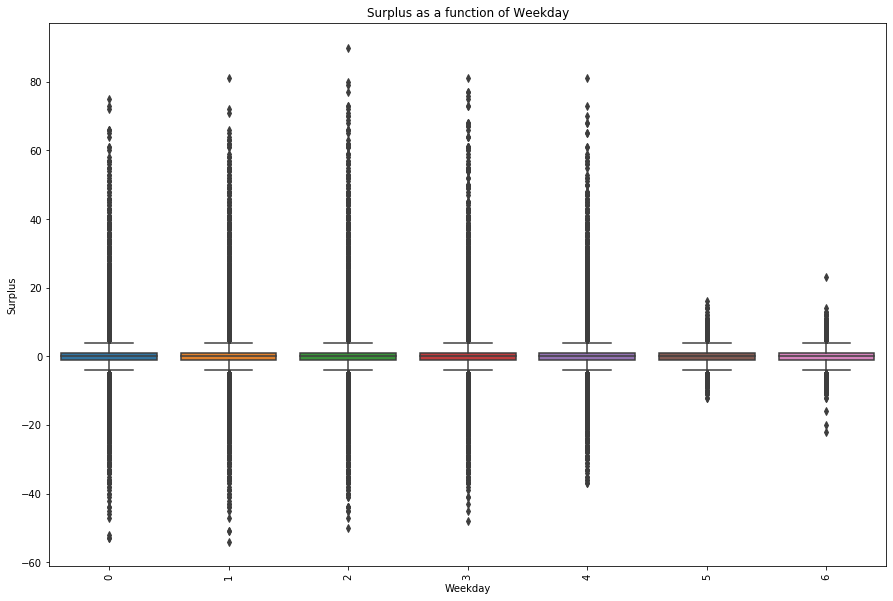

In [30]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Weekday'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Weekday')
plt.show()


In [28]:
ts = pd.to_datetime(X_df[['Year','Month','Day']])
X_df['Weekdday']=ts.dt.weekday
train_data['Weekday'] = ts.dt.weekday 
df=train_data[['Surplus','Weekday']].groupby('Weekday').mean()
pg=train_data.groupby(['Weekday','Hour']).mean()
pg.head()

Year     Month        Day   Station ID  Longitude  \
Weekday Hour                                                             
0       0.0   2017.055235  7.126958  15.732894  3244.070074 -74.047886   
        1.0   2016.984825  7.083460  15.851290  3240.069803 -74.048252   
        2.0   2016.930514  7.232628  16.235650  3243.474320 -74.049748   
        3.0   2017.107570  7.215139  15.541833  3239.135458 -74.051485   
        4.0   2017.081545  7.188841  16.354077  3237.302575 -74.048050   

               Latitude   Surplus  Current Load  
Weekday Hour                                     
0       0.0   40.723815  0.042869   4826.338005  
        1.0   40.723754  0.045524   5044.241275  
        2.0   40.724790 -0.018127   4742.009063  
        3.0   40.725281  0.035857   5441.147410  
        4.0   40.723005 -0.006438   5447.993562

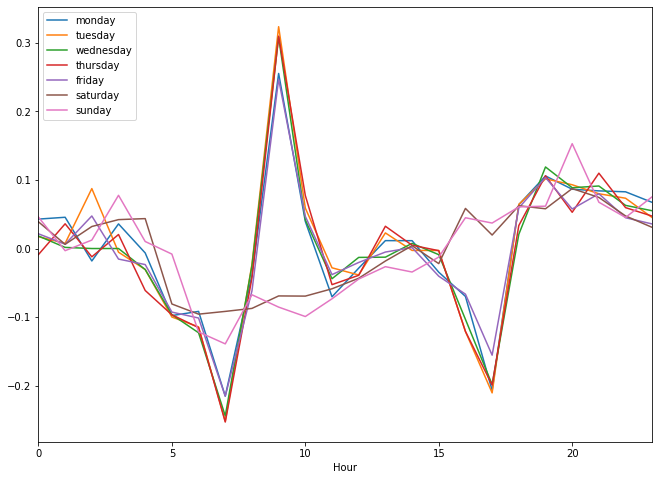

In [29]:
ax1 = plt.gca()
pg['Surplus'][0].plot(kind='line',ax=ax1,figsize=(11,8))
pg['Surplus'][1].plot(kind='line',ax=ax1)
pg['Surplus'][2].plot(kind='line',ax=ax1)
pg['Surplus'][3].plot(kind='line',ax=ax1)
pg['Surplus'][4].plot(kind='line',ax=ax1)
pg['Surplus'][5].plot(kind='line',ax=ax1)
pg['Surplus'][6].plot(kind='line',ax=ax1)
ax1.legend(['monday','tuesday','wednesday','thursday','friday','saturday','sunday'],loc='upper left')
plt.show()


Here it is interesting to notice that during weekdays (from Monday to Friday), we observe two negative peaks at 7AM and at 6PM and two positive pics at 9AM and 7-8PM. This remark can be interpreted as the following: customers use massively the bikes drive to work early in the morning and head back home at the end of the afternoon. This use implies a big number of bikes out and a fewer number of bikes in in these hours, which explains the negative pics. On the other hand, people are expected to arrive at their work place between 9 and 10 AM and to their homes between 7 and 8 PM. Consequently the number of bikes in start to increase, leading to an increase in the surplus.

As far as the weekends are concerned, here we notice a flat distribution with more bikes used during the day.

## Holiday

Federal and State Holidays:
- New Year: 1 January.
- Martin Luther King Jr. Day: Third Monday of January. In honour of Martin Luther King Jr who fought to defend racial equality.
- President’s Day: Third Monday of February. Celebrated in honour of George Washington and all of United States’ Presidents.
- Memorial Day: Last Monday of May. To remember the soldiers who died while serving in the country’s armed forces.
- Independence Day: 4 July. On the 4 July, 1776, 13 colonies became independent from British domination and formed the first States of the country.
- Labor day: First Monday of September
- Columbus Day: Second Monday of October. Remembers Christopher Columbus’ arrival to the Americas on 12 October, 1492.
- Veterans Day: 11 November. The anniversary of the signing of the armistice.
- Thanksgiving Day: Last Thursday of November.
- Christmas: 25 December.


In [30]:
## add is_Holiday : 1 if holiday, else 0 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal=calendar()
holidays = cal.holidays(start=ts.min(), end=ts.max()) # Holidays in the US
holidays

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
               '2016-11-24', '2016-12-26', '2017-01-02', '2017-01-16',
               '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25',
               '2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
               '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12',
               '2018-11-22', '2018-12-25', '2019-01-01'],
              dtype='datetime64[ns]', freq=None)

In [31]:
X_df['Is_Holiday'] = ts.apply(lambda x: int(x in holidays))
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Current Load,Weekdday,Is_Holiday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,1.0,4,1
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,0.0,4,1
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,2.0,4,1
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,-1.0,4,1
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,3.0,4,1


In [32]:
##Groupby is_holiday
train_data['Is_Holiday'] = ts.apply(lambda x: int(x in holidays))
df=train_data[['Surplus','Is_Holiday']].groupby('Is_Holiday').mean()
df

,Surplus
Is_Holiday,
0,-0.003583
1,-0.001285


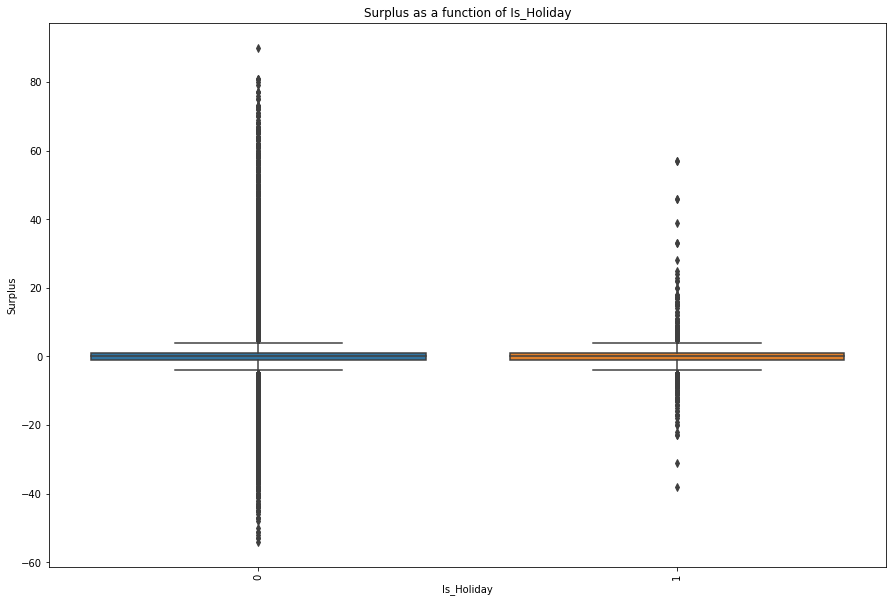

In [34]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Is_Holiday'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Is_Holiday')
plt.show()


# Predictions

In [114]:
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        return self

    def transform(self, X_df):
        weather = pd.read_csv('Data\Weather Data\Train_Weather.csv')

        def process_date(X):
            print(X.shape)
            return np.c_[X['Year'], X['Month'], X['Day'], X["Hour"]]
        date_transformer = FunctionTransformer(process_date, validate=False)
        
        def process_station(X):
            return np.c_[X['Station ID'], X['Longitude'], X['Latitude']]
        station_transformer = FunctionTransformer(process_station, validate=False)

        def process_weather(X):
            #date = pd.to_datetime(weather['Date'])
            #weather['Year'] = date.dt.year
            #weather['Month'] = date.dt.month
            #weather['Day'] = date.dt.day
            #weather['Hour'] = weather.Hour.apply(lambda x:int(x[:2]))
            #df = pd.merge(X, weather, on=['Year', 'Month', 'Day', 'Hour'], how='left')
            #df['Temperature'] = df['Temperature'].str[:-2]
            #df['Apparent Temperature'] = df['Apparent Temperature'].str[:-2]
            #print(df.columns)
            #print(df['Apparent Temperature'].shape, df['Temperature'].shape, X.shape)
            
            df = X.copy()
            df["temp_key"] = list(zip(df.Year, df.Month, df.Day, df.Hour))
            weather.Date = pd.to_datetime(weather.Date)
            weather["Year"] = weather.Date.apply(lambda x:x.year)
            weather["Month"] = weather.Date.apply(lambda x:x.month)
            weather["Day"] = weather.Date.apply(lambda x:x.day)
            weather["Hour"] = weather.Hour.apply(lambda x:int(x[:2]))
            dicts = weather.set_index(["Year", 'Month', 'Day', "Hour"])[["Temperature", "Apparent Temperature", "Wind", "Relative Humidity"]].to_dict()
            df["Temperature"] = df["temp_key"].map(dicts["Temperature"])
            df["Apparent Temperature"] = df["temp_key"].map(dicts["Apparent Temperature"])
            #X["Wind"] = X["temp_key"].map(dicts["Wind"])
            #X["Relative Humidity"] = X["temp_key"].map(dicts["Relative Humidity"])
            df['Temperature'] = df['Temperature'].str[:-2]
            df['Apparent Temperature'] = df['Apparent Temperature'].str[:-2]
            
            return df[["Temperature", "Apparent Temperature"]] #, 'Wind', 'Relative Humidity']]        
        weather_transformer = FunctionTransformer(process_weather, validate=False)


        date_cols = ['Year', 'Month', 'Day', "Hour"]
        station_cols = ['Station ID', 'Longitude', 'Latitude']
        merge_col = ['Year', 'Month', 'Day', 'Hour']

        preprocessor = ColumnTransformer(
            transformers=[
                ('weather', make_pipeline(weather_transformer, SimpleImputer(strategy='median')), merge_col),
                ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
                ('station', make_pipeline(station_transformer, SimpleImputer(strategy='median')), station_cols),
            ])

        X_array = preprocessor.fit_transform(X_df)
        return X_array

In [115]:
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596


In [116]:
X_transformed = FeatureExtractor().transform(X_df)

(511903, 4)


In [117]:
X_transformed.shape

(511903, 9)

In [118]:
X_transformed[0, :]

array([ 6.00000000e+00,  4.00000000e+00,  2.01600000e+03,  1.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  3.20300000e+03, -7.40442473e+01,
        4.07275960e+01])

In [119]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [121]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit

preprocessor = FeatureExtractor()
regressor = Regressor()

reg = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', regressor)])

cv = GroupShuffleSplit(n_splits=2, test_size=0.25)

scores_merge = -cross_val_score(reg, X_df, y_array, cv=cv, scoring=pinball_loss, groups=X_df['Station ID'],
                               n_jobs=2)

In [122]:
scores_merge

array([1.36534217, 1.2422722 ])

In [123]:
y_array 

array([ 1.,  0.,  2., ..., -1., -1., -1.])

In [136]:
random_losses = []#uniform - add distribution from actual training data
for k in range(1000):
    random_losses.append(loss(y_array, np.random.randint(-3, 3, len(y_array))))

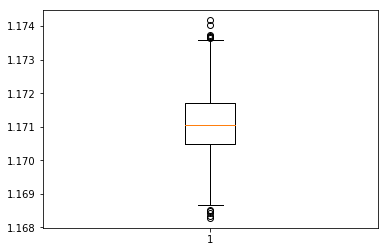

In [138]:
plt.boxplot(random_losses);

In [132]:
loss(y_array, np.median(y_array))

0.9982535753843991

## Writing files and testing

In [18]:
%%file submissions/starting_kit/feature_extractor.py
import os
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline


class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        return self

    def transform(self, X_df):

        path = os.path.dirname(__file__)
        weather = pd.read_csv(os.path.join(path, 'weather.csv.zip'))

        def process_date(X):
            return np.c_[X['Year'], X['Month'], X['Day']]
        date_transformer = FunctionTransformer(process_date, validate=False)
        
        def process_station(X):
            return np.c_[X['Station ID'], X['Longitude'], X['Latitude']]
        station_transformer = FunctionTransformer(process_station, validate=False)

        def process_weather(X):
            date = pd.to_datetime(weather['Date'], format='%Y-%m-%d')
            weather['Year'] = date.dt.year
            weather['Month'] = date.dt.month
            weather['Day'] = date.dt.day
            weather['Hour'] = pd.to_datetime(weather['Hour'], format='%H:%M').dt.hour
            df = pd.merge(X, weather, on=['Year', 'Month', 'Day', 'Hour'], how='inner')
            df['Temperature'] = df['Temperature'].str[:-2]
            df['Apparent Temperature'] = df['Apparent Temperature'].str[:-2]
            print(X.shape, weather.shape, df.shape)
            return df[['Temperature', 'Apparent Temperature']] #, 'Wind', 'Relative Humidity']]        
        weather_transformer = FunctionTransformer(process_weather, validate=False)


        date_cols = ['Year', 'Month', 'Day']
        station_cols = ['Station ID', 'Longitude', 'Latitude']
        merge_col = ['Year', 'Month', 'Day', 'Hour']

        preprocessor = ColumnTransformer(
            transformers=[
                ('weather', make_pipeline(weather_transformer, SimpleImputer(strategy='median')), merge_col),
                ('date', make_pipeline(date_transformer, SimpleImputer(strategy='median')), date_cols),
                ('station', make_pipeline(station_transformer, SimpleImputer(strategy='median')), station_cols),
            ])

        X_array = preprocessor.fit_transform(X_df)
        return X_array

Overwriting submissions/starting_kit/feature_extractor.py


In [19]:
%%file submissions/starting_kit/regressor.py
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=5)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

Overwriting submissions/starting_kit/regressor.py


In [16]:
!ramp_test_submission

Testing Prediction of NYC bike sharing service usage per station
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  pinball loss      time
	train          1.59  3.869853
	valid          2.74  0.636875
	test           1.91  0.260510
CV fold 1
	score  pinball loss      time
	train          1.76  4.118824
	valid          1.51  0.621962
	test           1.90  0.268351
CV fold 2
	score  pinball loss      time
	train          1.75  3.862787
	valid          1.83  0.631975
	test           1.90  0.269093
CV fold 3
	score  pinball loss      time
	train          1.62  2.915968
	valid          2.16  0.592363
	test           1.91  0.250132
CV fold 4
	score  pinball loss      time
	train          1.78  3.588375
	valid          1.65  0.606002
	test           1.90  0.253151
CV fold 5
	score  pinball loss      time
	train          1.47  3.418429
	valid          3.04  0.609333
	test           1.90  0.259379
CV fold 6
	score  pinball loss   

In [16]:
# ENLEVER CA
# weather_train = pd.read_csv('Data/Weather Data/Train_Weather.csv')
# weather_test = pd.read_csv('Data/Weather Data/Test_Weather.csv')
# weather = pd.concat([weather_train, weather_test])
# weather.to_csv('submissions/starting_kit/weather.csv.zip')